<a href="https://colab.research.google.com/github/EstebanPiacentino/GAN4DataAnonymization/blob/master/GAN_with_PyTorch_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
cd /gdrive/My Drive/Colab Notebooks

/gdrive/My Drive/Colab Notebooks


In [0]:
#Dependencies
import numpy as np
import os
from skimage import io, transform
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from random import choice

from zipfile import ZipFile
import io as ios

In [0]:
#Leer imagenes desde el zip

#from zipfile import ZipFile
#import io as ios
#
#archive = ZipFile("Fingerprints.zip", 'r')
#image_data = ios.BytesIO(archive.read("0.jpg"))
#out=io.imread(image_data)
#
#plt.imshow(out)

#cd /gdrive/My Drive/Colab Notebooks/Fingerprints
#!unzip 'Fingerprints.zip'
#rm finger_{1..2}.jpg


In [0]:
class FingerprintsDataset(Dataset):
    """Fingerprints dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.archive = ZipFile(self.root_dir, 'r')

    def __len__(self):
        return 75600 #Total number of images

    def __getitem__(self, idx):
        img_data = ios.BytesIO(self.archive.read(str(idx)+'.jpg'))
        image = io.imread(img_data)

        if self.transform:
            image = self.transform(image)

        return image

In [0]:
class IrisDataset(Dataset):
    """Iris dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.archive = ZipFile(self.root_dir, 'r')

    def __len__(self):
        return 2240 #Total number of images

    def __getitem__(self, idx):
        path=''
        dir1=str(int(idx/10)+1)
        dir1_path=dir1.zfill(3)+'/'
        
        filename=str(int(idx%10)+1)
        side='R' if int(filename)>5 else 'L'
        try:
          filename_path=filename.zfill(2)+'_'+side+'.bmp'
          path=dir1_path+filename_path
          
          img_data = ios.BytesIO(self.archive.read(path))
          image = io.imread(img_data)
        except:
          if side=='R':
            side='L'
            filename_path=filename.zfill(2)+'_'+side+'.bmp'
            path=dir1_path+filename_path
          
            img_data = ios.BytesIO(self.archive.read(path))
            image = io.imread(img_data)
          else:
            side='R'
            filename_path=filename.zfill(2)+'_'+side+'.bmp'
            path=dir1_path+filename_path
          
            img_data = ios.BytesIO(self.archive.read(path))
            image = io.imread(img_data)

        if self.transform:
            image = self.transform(image)

        return image

In [0]:
#Load
out_dir = './Iris_dataset' #saves dataset here
transform =  transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(),transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))])
#download MNIST, save and apply transform 
iris_data =  IrisDataset(root_dir='IrisDB.zip', transform=transform)
#Data loader feeds data as inputs and labels, of fixed batch size
train_loader = torch.utils.data.DataLoader(iris_data, batch_size = 20, shuffle = True)


In [0]:
#Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
#Define discriminator
def disc_model():
    discriminator_model = nn.Sequential(
      nn.Linear(320*240, 2048),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(2048, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024 , 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512 , 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256 , 1),
      nn.Sigmoid()
      ).to(device)
    return discriminator_model
#create a discriminator network
discriminator = disc_model()
#if we want to start from a checkpoint model
discriminator.load_state_dict(torch.load('f_name_lastIris.pth')['dis_state_dict'])
discriminator.eval()

Sequential(
  (0): Linear(in_features=76800, out_features=2048, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Dropout(p=0.3)
  (3): Linear(in_features=2048, out_features=1024, bias=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Dropout(p=0.3)
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout(p=0.3)
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Dropout(p=0.3)
  (12): Linear(in_features=256, out_features=1, bias=True)
  (13): Sigmoid()
)

In [0]:
#Define generator
def gen_model():
    generator_model = nn.Sequential(
          nn.Linear(100, 256),
          nn.LeakyReLU(0.2),
          nn.Linear(256 , 512),
          nn.LeakyReLU(0.2),
          nn.Linear(512 , 1024),
          nn.LeakyReLU(0.2),
          nn.Linear(1024 , 2048),
          nn.LeakyReLU(0.2),
          nn.Linear(2048 , 320*240),
          nn.Tanh()    
          ).to(device)
    return generator_model
#create a generator network
generator = gen_model()
#if we want to start from a checkpoint model
generator.load_state_dict(torch.load('f_name_lastIris.pth')['gen_state_dict'])
generator.eval()

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Linear(in_features=2048, out_features=76800, bias=True)
  (9): Tanh()
)

In [0]:
#Noise generator
from torch.autograd import Variable
def rand_vecs(batch_size):
    return Variable(torch.randn(batch_size, 100)).to(device)

In [0]:
#Define optimizer and loss criterion
import torch.optim as optim
#create separate optimizers, use BCELoss for both networks
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)
criterion = nn.BCELoss()

In [0]:
#Get the labels
def ones_or_zeros(batch_size, labels):
    if labels == 1:
        return Variable(torch.ones(batch_size, 1)).to(device)
    elif labels == 0:
        return Variable(torch.zeros(batch_size, 1)).to(device)

In [0]:
#TRAIN
#Create empty lists to catch losses
losses_disc, losses_generator = [], []
print_freq = 5 #fix how frequently to print losses
for epoch in range(36,101): #100 by default
    #Networks are training hence, .train()
    discriminator.train()
    generator.train()
    
#Train discriminator
    tot_inputs_passed=0
    for inputs in train_loader:
        
        #.to(device)--> work in either cpu or gpu     
        inputs = inputs.to(device) 
        
        batch_size = inputs.size(0)
        #Note: inputs.shape ->([52, 1, 28, 28])        
        #reshape to (batch_size, features) as expected by network
        real_data = inputs.view(inputs.size(0), -1) 
        
        #Flush the retained gradients
        d_optimizer.zero_grad()
        # probabilities given real data       
        pred_real = discriminator(real_data) 
        
        #Computing loss for real data         
        loss_real=criterion(pred_real, ones_or_zeros(batch_size, 1))
        
        #Note grads for gen are detached
        fake_data = generator(rand_vecs(batch_size)).detach()
 
        fake_data = fake_data.to(device)
        # probabilities given fake data
        pred_fake = discriminator(fake_data) 
        
        #Computing loss for generated data
        loss_fake=criterion(pred_fake, ones_or_zeros(batch_size, 0))
        
        loss_disc = loss_real + loss_fake  #combined loss
        losses_disc.append(loss_disc.item()) # log the losses
        #computes the gradients        
        loss_disc.backward()
        #update parameters using gradients & optimizer rules       
        d_optimizer.step()
 
        #discriminator completes a loop
#Train generator
        #Trains from scratch, newly generated data are used
        g_optimizer.zero_grad()
        #generates image/feature vector
        fake_data_new = generator(rand_vecs(batch_size))  
               
        fake_data_new = fake_data_new.to(device)
        
        pred_fake_new = discriminator(fake_data_new)
        #Generator's loss minimized after, labels are set to 1 
        loss_generator = criterion(pred_fake_new,   ones_or_zeros(batch_size, 1))
 
        losses_generator.append(loss_generator.item())
        loss_generator.backward()
        
        g_optimizer.step() #completes training loop for generator
        
        #Printing the Evolution:
        #image=generator(rand_vecs(batch_size))[0]
        #image_host=image.cpu()
        #sample=image_host.view(-1, 275).detach().numpy()
        #plt.axis('off')
        #plt.grid(b=None)
        #plt.imshow(sample)
        #plt.show()
            
        tot_inputs_passed+=1       
        
        print('\r',str(round(float(tot_inputs_passed)/len(train_loader)*100,2))+"% Epoch passed",end='')
        
#Print and save epoch, generator_state_dict as chk_point
    if epoch % print_freq ==0:
        print("loss_disc:{:.6}.., loss_generator: {:.5}".format(loss_disc, loss_generator))
        torch.save({
            'epoch': epoch,
            'gen_state_dict': generator.state_dict(),
            'dis_state_dict': discriminator.state_dict(),
            }, ('f_name_' + 'lastIris' + '.pth'))
        torch.save({
            'epoch': epoch,
            'losses': "loss_disc:{:.6}.., loss_generator: {:.5}".format(loss_disc, loss_generator),
            }, ('f_name_iris_' + str(epoch) + '.txt'))
        fig=plt.figure(figsize=(8, 11))
        columns = 3
        rows = 3
        for i in range(1, columns*rows +1):
            image=generator(rand_vecs(batch_size))[choice(range(batch_size))]
            image_host=image.cpu()
            sample=image_host.view(-1, 320).detach().numpy()
            #can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
            fig.add_subplot(rows, columns, i)
            plt.axis('off')
            plt.grid(b=None)
            im=plt.imshow(sample)
            im.set_cmap('Greys')
            plt.imsave('Epoch_'+str(epoch)+'_sample_iris_'+str(i)+'.png', sample)
        plt.show()
    else:
        print("\nNew epoch: "+str(epoch+1))

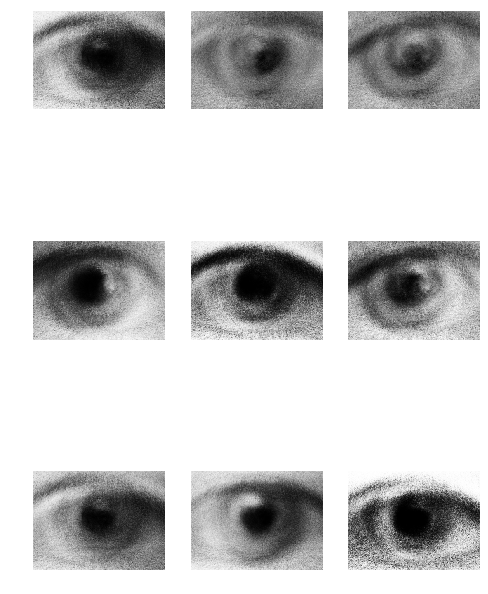

In [0]:
#Loading Images

generator=gen_model()
generator.load_state_dict(torch.load('f_name_lastIris.pth')['gen_state_dict'])
generator.eval()

fig=plt.figure(figsize=(8, 12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    image=generator(rand_vecs(20))[choice(range(20))]
    image_host=image.cpu()
    sample=image_host.view(-1, 320).detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(b=None)
    im=plt.imshow(sample)
    im.set_cmap('gist_gray')
    plt.imsave('Final_iris_Result_'+str(i)+'.png', sample, cmap='gist_gray')
plt.show()